# Bonito

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import functools

from fastai.basics import *

import jkbc.utils.preprocessing as prep
import jkbc.utils.postprocessing as pop
import jkbc.utils.files as f
import jkbc.types as t
import jkbc.utils.loss as jloss
import toml
import tqdm

In [3]:
D_out_max = 70
C = 5
D_out_seq_len = 100
BS = 1024
DEVICE = torch.device("cuda:0")
model_name = "bonito-5000"

In [4]:
base_dir = Path("../../")
path_data = base_dir/"data"
data_set_name = f'Range0-100-FixLabelLen{D_out_max}'
feather_folder = path_data/"feather-files"/data_set_name

In [5]:
# Read data from feather
data_feather = f.read_data_from_feather_file(feather_folder)

# Convert to databunch
train_dl, valid_dl = prep.convert_to_dataloaders(data_feather, split=.8, batch_size=BS, drop_last=True)
data = DataBunch(train_dl, valid_dl, device=DEVICE)
del train_dl
del valid_dl
torch.cuda.empty_cache()

## Define the Model

In [6]:
activations = {
    "relu": nn.ReLU,
    "leaky_relu": nn.LeakyReLU,
}


class Model(nn.Module):
    """
    Model template for QuartzNet style architectures

    https://arxiv.org/pdf/1910.10261.pdf
    """
    def __init__(self, config):
        super(Model, self).__init__()
        self.stride = config['block'][0]['stride'][0]
        self.alphabet = config['labels']['labels']
        self.features = config['block'][-1]['filters']
        self.encoder = Encoder(config)
        self.decoder = Decoder(self.features, len(self.alphabet))

    def forward(self, x):
        encoded = self.encoder(x)
        return self.decoder(encoded)


class Encoder(nn.Module):
    """
    Builds the model encoder
    """
    def __init__(self, config):
        super(Encoder, self).__init__()
        self.config = config

        features = self.config['input']['features']
        activation = activations[self.config['encoder']['activation']]()
        encoder_layers = []

        for layer in self.config['block']:
            encoder_layers.append(
                Block(
                    features, layer['filters'], activation,
                    repeat=layer['repeat'], kernel_size=layer['kernel'],
                    stride=layer['stride'], dilation=layer['dilation'],
                    dropout=layer['dropout'], residual=layer['residual'],
                    separable=layer['separable'],
                )
            )

            features = layer['filters']

        self.encoder = nn.Sequential(*encoder_layers)

    def forward(self, x):
        return self.encoder([x])


class TCSConv1d(nn.Module):
    """
    Time-Channel Separable 1D Convolution
    """
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=False, separable=False):

        super(TCSConv1d, self).__init__()
        self.separable = separable

        if separable:
            self.depthwise = nn.Conv1d(
                in_channels, in_channels, kernel_size=kernel_size, stride=stride,
                padding=padding, dilation=dilation, bias=bias, groups=in_channels
            )

            self.pointwise = nn.Conv1d(
                in_channels, out_channels, kernel_size=1, stride=stride,
                dilation=dilation, bias=bias, padding=0
            )
        else:
            self.conv = nn.Conv1d(
                in_channels, out_channels, kernel_size=kernel_size,
                stride=stride, padding=padding, dilation=dilation, bias=bias
            )

    def forward(self, x):
        if self.separable:
            x = self.depthwise(x)
            x = self.pointwise(x)
        else:
            x = self.conv(x)
        return x


class Block(nn.Module):
    """
    TCSConv, Batch Normalisation, Activation, Dropout
    """
    def __init__(self, in_channels, out_channels, activation, repeat=5, kernel_size=1, stride=1, dilation=1, dropout=0.0, residual=False, separable=False):

        super(Block, self).__init__()

        self.use_res = residual
        self.conv = nn.ModuleList()

        _in_channels = in_channels
        padding = self.get_padding(kernel_size[0], stride[0], dilation[0])

        # add the first n - 1 convolutions + activation
        for _ in range(repeat - 1):
            self.conv.extend(
                self.get_tcs(
                    _in_channels, out_channels, kernel_size=kernel_size,
                    stride=stride, dilation=dilation,
                    padding=padding, separable=separable
                )
            )

            self.conv.extend(self.get_activation(activation, dropout))
            _in_channels = out_channels

        # add the last conv and batch norm
        self.conv.extend(
            self.get_tcs(
                _in_channels, out_channels,
                kernel_size=kernel_size,
                stride=stride, dilation=dilation,
                padding=padding, separable=separable
            )
        )

        # add the residual connection
        if self.use_res:
            self.residual = nn.Sequential(*self.get_tcs(in_channels, out_channels))

        # add the activation and dropout
        self.activation = nn.Sequential(*self.get_activation(activation, dropout))

    def get_activation(self, activation, dropout):
        return activation, nn.Dropout(p=dropout)

    def get_padding(self, kernel_size, stride, dilation):
        if stride > 1 and dilation > 1:
            raise ValueError("Dilation and stride can not both be greater than 1")
        return (kernel_size // 2) * dilation

    def get_tcs(self, in_channels, out_channels, kernel_size=1, stride=1, dilation=1, padding=0, bias=False, separable=False):
        return [
            TCSConv1d(
                in_channels, out_channels, kernel_size,
                stride=stride, dilation=dilation, padding=padding,
                bias=bias, separable=separable
            ),
            nn.BatchNorm1d(out_channels, eps=1e-3, momentum=0.1)
        ]

    def forward(self, x):
        _x = x[0]
        for layer in self.conv:
            _x = layer(_x)
        if self.use_res:
            _x += self.residual(x[0])
        return [self.activation(_x)]


class Decoder(Module):
    """
    Decoder
    """
    def __init__(self, features, classes):
        super(Decoder, self).__init__()
        self.layers = nn.Sequential(nn.Conv1d(features, classes, kernel_size=1, bias=True))

    def forward(self, x):
        x = self.layers(x[-1])
        return nn.functional.log_softmax(x.transpose(1, 2), dim=2)


## Load the Config

In [19]:
config = toml.load("quartznet5x5.toml")

In [20]:
model = Model(config).to(device=DEVICE)

In [21]:
learn = Learner(data, model, loss_func=jloss.ctc_loss(D_out_seq_len, BS, C), wd=0.1)

In [14]:
try:
    learn.load(model_name)
    print(f"Model weights loaded from: {model_name}")
except:
    print("No weights were loaded..")

Model weights loaded from: bonito-5000


In [15]:
# Check output size
#xb, yb = data.one_batch(); xb = xb.cuda(); y_pred = model(xb); y_pred.shape

epoch,train_loss,valid_loss,time
0,1.537147,#na#,00:14
1,1.537084,#na#,00:14
2,1.536789,#na#,00:14
3,1.537197,#na#,00:14
4,1.542228,#na#,00:14
5,1.560905,#na#,00:14
6,1.565063,#na#,00:14
7,4.256651,#na#,00:13


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.32E-06
Min loss divided by 10: 2.29E-07


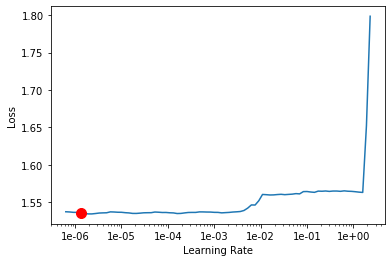

In [16]:
learn.lr_find(); learn.recorder.plot(suggestion=True)

In [18]:
for i in tqdm.tqdm(range(100)):
    learn.fit_one_cycle(1, max_lr=1.32e-06)    
    learn.save(model_name+"smaller")


  0%|          | 0/100 [00:00<?, ?it/s]

epoch,train_loss,valid_loss,time
0,1.537053,1.534068,00:14



  1%|          | 1/100 [00:15<25:11, 15.27s/it]

epoch,train_loss,valid_loss,time
0,1.536966,1.533981,00:14



  2%|▏         | 2/100 [00:30<24:52, 15.22s/it]

epoch,train_loss,valid_loss,time
0,1.536884,1.533898,00:15



  3%|▎         | 3/100 [00:45<24:42, 15.28s/it]

epoch,train_loss,valid_loss,time
0,1.536806,1.533821,00:15



  4%|▍         | 4/100 [01:01<24:32, 15.34s/it]

epoch,train_loss,valid_loss,time
0,1.536734,1.533746,00:15



  5%|▌         | 5/100 [01:16<24:20, 15.37s/it]

epoch,train_loss,valid_loss,time
0,1.536666,1.533677,00:14



  6%|▌         | 6/100 [01:31<24:00, 15.32s/it]

epoch,train_loss,valid_loss,time


KeyboardInterrupt: 

In [18]:
x, (y, _) = data.one_batch()
y_pred = model(x.to(device=DEVICE)).detach().cpu().numpy()
y[0]

tensor([2, 3, 1, 2, 1, 4, 2, 3, 1, 3, 3, 4, 3, 2, 2, 1, 1, 1, 2, 2, 4, 2, 2, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
index = 0
actual = pop.convert_idx_to_base_sequence(y[index])
print(actual)
for beam in range(25):
    decoded = pop.decode(y_pred, threshold=.0, beam_size=beam)   
    predicted = decoded[index]
    error = pop.calc_sequence_error_metrics(actual, predicted)
    print(predicted, beam, error.error)
    del predicted

In [11]:
torch.cuda.empty_cache()